In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer

In [2]:
img_l = np.asanyarray(Image.open("im2.png").resize((450,375)).convert("L")).astype(np.int)
img_r = np.asanyarray(Image.open("im7.png").resize((450,375)).convert("L")).astype(np.int)

In [96]:
img_l = np.asanyarray(Image.open("im2.png").convert("L")).astype(np.int)
img_r = np.asanyarray(Image.open("im6.png").convert("L")).astype(np.int)

In [3]:
img_r.shape

(375, 450)

In [97]:
kg_max=65
kv_max=10
kv_half = kv_max//2

alpha=30

height = img_r.shape[0]
length = img_r.shape[1]

g = np.zeros((kg_max*kv_max, kg_max*kv_max), dtype=np.int)
for k1 in range(kg_max*kv_max):
    for k2 in range(kg_max*kv_max):
        kg1 = k1 % kg_max
        kv1 = k1 // kg_max
        kg2 = k2 % kg_max
        kv2 = k2 // kg_max
        #kg1 *= 2
        #kv1 *= 2
        #kg2 *= 2
        #kv2 *= 2
        g[k1,k2] = abs(kg1 - kg2) +  abs(kv1 - kv2)
g = alpha*g

In [5]:
kg1

64

In [6]:
kv1

19

In [ ]:
start = timer()
img_shift = np.ones(img_l.shape)

for i in range(img_shift.shape[0]):
    start = timer()
    f = 49999*np.ones((length, kg_max*kv_max), dtype=np.int)
    for k in range(1, kg_max*kv_max):
        kg1 = k % kg_max
        kv1 = k // kg_max
        #kg1 *= 2
        #kv1 *= 2
        if kv1 <= kv_half and i + kv1 < height:
            f[:length-kg1, k] = np.abs(img_r[i,:length-kg1] - img_l[i+kv1,kg1:])
        elif kv1 > kv_half and i + (kv_half - kv1) < height:
            f[:length-kg1, k] = np.abs(img_r[i+(kv_half - kv1),:length-kg1] - img_l[i,kg1:])

    end = timer()
    print('\n\nconstruct graph:',timedelta(seconds=end-start))            
    start = timer()

    pass_to_prev = np.zeros(f.shape, dtype=np.int)
    for p in range(1, length):
        ta = f[p-1, :] + g
        ind = np.argmin(ta, axis=1)
        f[p, :] += np.min(ta, axis=1)
        pass_to_prev[p, :] = ind
    
    end = timer()
    print('\n\nfind path:',timedelta(seconds=end-start))
    start = timer()
    
    line_shift = np.ones(length, dtype=np.int)
    line_shift[-1] = np.argmin(f[-1,:])
    for p in reversed(range(length-1)):
        line_shift[p] = pass_to_prev[p+1, line_shift[p+1]]
    
    img_shift[i] = line_shift
    end = timer()
    print('\n\nrecover path:',timedelta(seconds=end-start)) 

    print(i, end=" ")
    print("\n"+20*"=")

end = timer()
print('\n\n\nTime per image',timedelta(seconds=end-start))

In [99]:
img_shift2 = np.zeros((height, length, 3), dtype=np.int)
img_shift2[:,:,0] = img_shift % kg_max # horizontal
img_shift2[:,:,1] = img_shift // kg_max # vertical


img_shift2[:,:,0] = 255*img_shift2[:,:,0]/img_shift2[:,:,0].max()
#img_shift2[:,:,1] -= img_shift2[:,:,1]

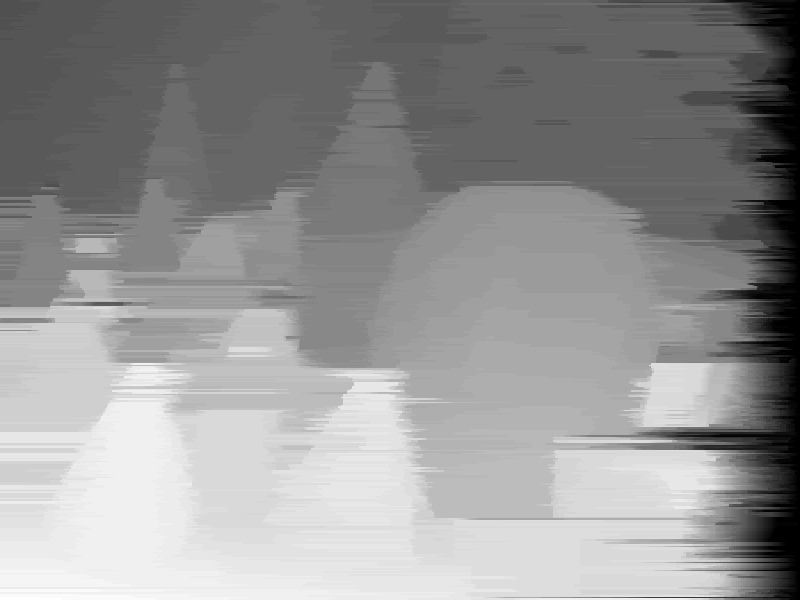

In [102]:
a = Image.fromarray(img_shift2[:,:,0].astype(np.uint8)).resize((800,600))#, Image.BICUBIC)
a

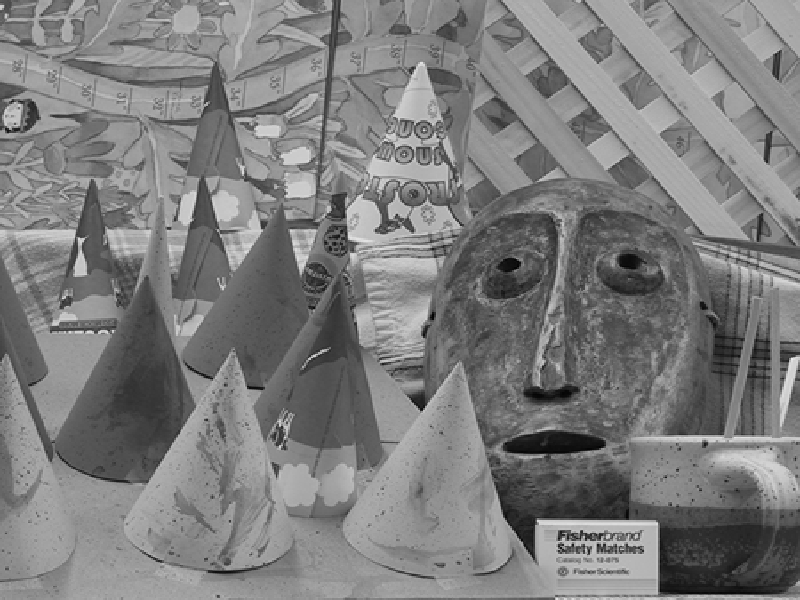

In [120]:
Image.fromarray(img_l.astype(np.uint8)).resize((800,600))